# **EDA of 400 samples from amazon_del**  
Here I am doing an EDA on this sample in order to prepare them for a prediction model of Delivery time.  

## **Packages**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from geopy.geocoders import Nominatim
import haversine as hs
from haversine import Unit
from modules_amazon import Location
import pickle

# **Checking** 

## **Cities**  
I have previously define the cities using the modules_amazon. However, in the EDA of the amazon_delivery I found 3180 rows with null coordinates of Store (represents around 7% of the all dataset).  
Here, I will check the cities that loc.city() had found. Especially where the corrdinates of the Store were null.

In [63]:
#no_city = amazon_sample400[amazon_sample400["City"].isna()]

In [64]:
#from geopy.geocoders import Nominatim
#from modules_amazon import Location
#import time
#cities = []
#for lat,long in zip(no_city["abs_Store_Latitude"],\
#                    no_city["abs_Store_Longitude"]):
#    loc=Location(lat,long)
#    cities.append(loc.city())
 #   time.sleep(1)

In [65]:
#amazon_sample400["City"] = amazon_sample400["City"].fillna(pd.Series(cities,\
                            #index=amazon_sample400[amazon_sample400["City"].isna()].index))

In [66]:
#with open("amazon_new400_samples.pkl","wb") as f:
#    pickle.dump(amazon_sample400,f)

In [67]:
with open("amazon_new400_samples.pkl","rb") as f:
    amazon_sample400 = pickle.load(f)

In [68]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

I apparently don't have any null Store coordinates values in my sample.  
The only null City value was one that was found to be in Pune City. During the calculation (which requires internet access) this row might have been skipped.  

In [69]:
print(amazon_sample400["City"].unique())

['' 'Jaipur' 'Mysuru' 'Bhopal' 'Ranchi' 'Chennai' 'Pune City' 'Ernakulam'
 'Hyderabad' 'Dehradun' 'Mumbai Suburban' 'Bengaluru'
 'Jaipur Municipal Corporation' 'Indore' 'Chhatrapati Sambhaji Nagar'
 'Coimbatore' 'Agra' 'Ludhiana' 'Mumbai City' 'Vadodara' 'Prayagraj'
 'Surat' 'Pimpri-Chinchwad' 'Kanpur' 'Kolkata' 'Panaji']


In [70]:
amazon_sample400["City"] = amazon_sample400["City"].replace("","Unknown")

# **Delivery_Time, our dependent variable**

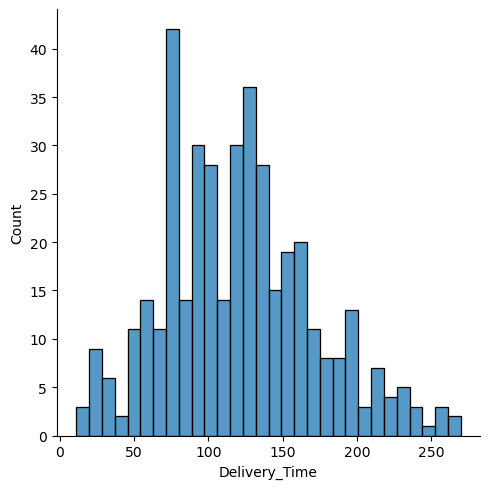

In [71]:
sns.displot(amazon_sample400["Delivery_Time"], bins=30)

The delivery time distribution is not normal but it's closed to normal.

In [72]:
amazon_sample400["Delivery_Time"].describe()

count    400.000000
mean     120.927500
std       50.989283
min       11.000000
25%       85.000000
50%      120.000000
75%      151.250000
max      270.000000
Name: Delivery_Time, dtype: float64

# **The numerical features**

In [73]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

- Agent_Age;  
- Agent_Rating;  
- Distance_Store_Drop_km;  


## **Agent_Age**

<Axes: xlabel='Agent_Age', ylabel='Delivery_Time'>

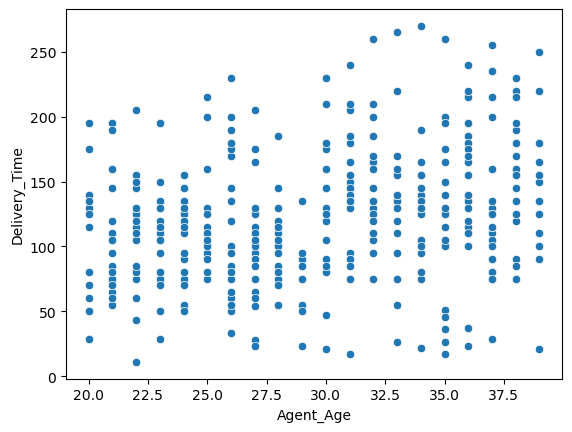

In [74]:
sns.scatterplot(x="Agent_Age", y="Delivery_Time", data=amazon_sample400)

In [75]:
amazon_sample400["Agent_Age"].describe()

count    400.000000
mean      29.642500
std        5.679819
min       20.000000
25%       25.000000
50%       30.000000
75%       35.000000
max       39.000000
Name: Agent_Age, dtype: float64

<Axes: ylabel='Agent_Age'>

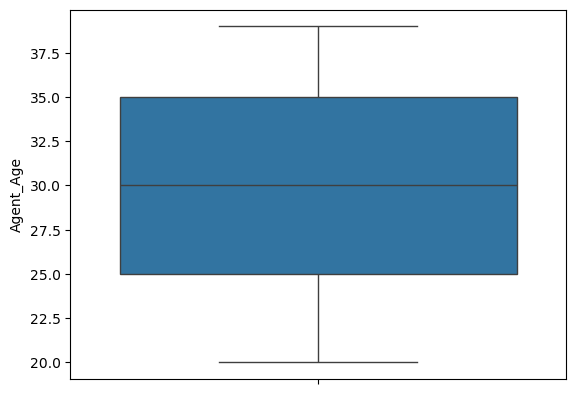

In [76]:
sns.boxplot(y="Agent_Age", data=amazon_sample400)

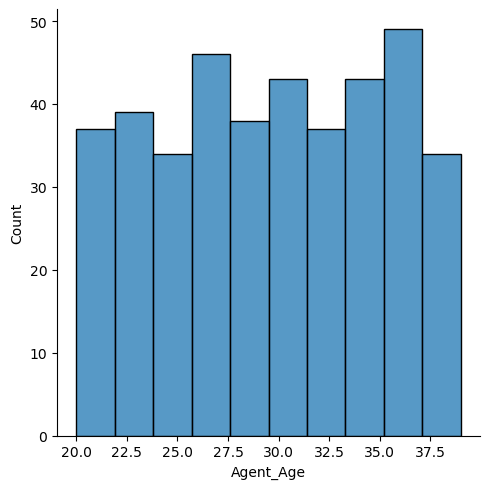

In [77]:
sns.displot(amazon_sample400["Agent_Age"])

no outliers. Also its distribution can be considered closed to a uniform distribution.
We could see 2 populations of agent_age based on their delivery_Time. Agents aged under 30 show a fastest delivery time while agents aged 30 or above show a tendency to deliver slower.

In [78]:
amazon_sample400["Young_vs_Older_Agents"] = np.where(amazon_sample400["Agent_Age"] < 30, "Under 30","30+")
amazon_sample400["Young_vs_Older_Agents"] = amazon_sample400["Young_vs_Older_Agents"].astype("category")
order_age_range = ["Under 30", "30+"]
amazon_sample400["Young_vs_Older_Agents"] = amazon_sample400["Young_vs_Older_Agents"].cat.\
    reorder_categories(new_categories=order_age_range, ordered=True)


In [79]:
amazon_sample400["Young_vs_Older_Agents"] = np.where(amazon_sample400["Young_vs_Older_Agents"] == "Under 30",0,1)

In [80]:
amazon_sample400["Young_vs_Older_Agents"].value_counts(normalize=True)

Young_vs_Older_Agents
1    0.515
0    0.485
Name: proportion, dtype: float64

<Axes: xlabel='Young_vs_Older_Agents', ylabel='Delivery_Time'>

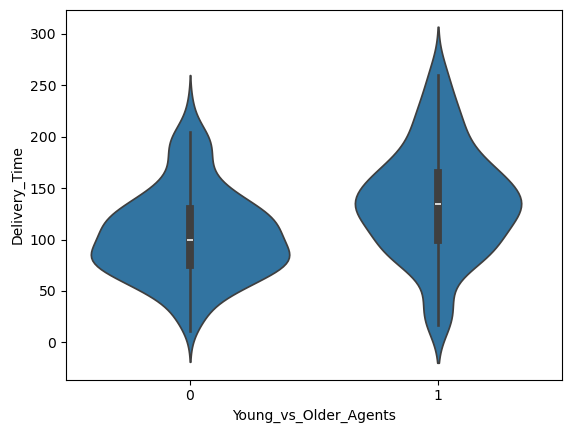

In [81]:
sns.violinplot(x="Young_vs_Older_Agents", y="Delivery_Time", data=amazon_sample400)

In [82]:
amazon_sample400.groupby("Young_vs_Older_Agents")["Delivery_Time"].describe()

,count,mean,std,min,25%,50%,75%,max
Young_vs_Older_Agents,,,,,,,,
0,194.0,104.597938,42.745096,11.0,75.0,100.0,130.0,230.0
1,206.0,136.305825,53.386567,17.0,100.0,135.0,165.0,270.0


## **Agent_Rating**

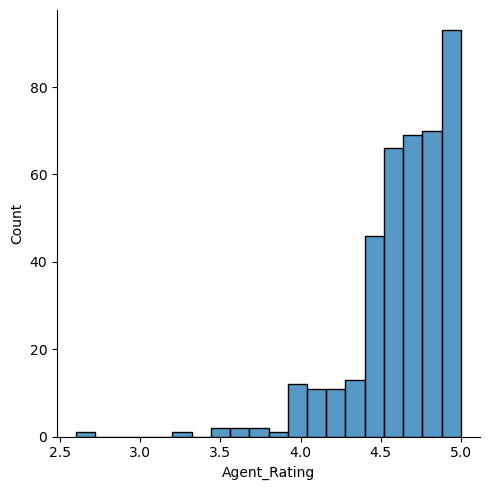

In [83]:
sns.displot(amazon_sample400["Agent_Rating"],bins=20)

Agent_Rating is not normally distributed.

In [84]:
amazon_sample400["Agent_Rating"].describe()

count    400.000000
mean       4.640000
std        0.305341
min        2.600000
25%        4.500000
50%        4.700000
75%        4.800000
max        5.000000
Name: Agent_Rating, dtype: float64

<Axes: xlabel='Agent_Rating', ylabel='Delivery_Time'>

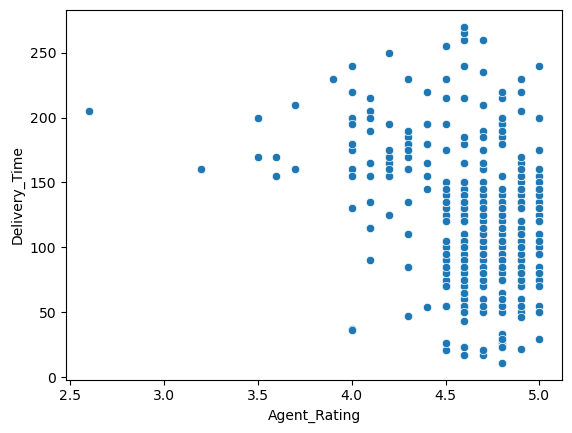

In [85]:
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=amazon_sample400)

Most of the ratings are between 4.5 and 5 and most of those ratings have a delivery time inferior to 150 minutes.

## **Distance_Store_Drop_km**

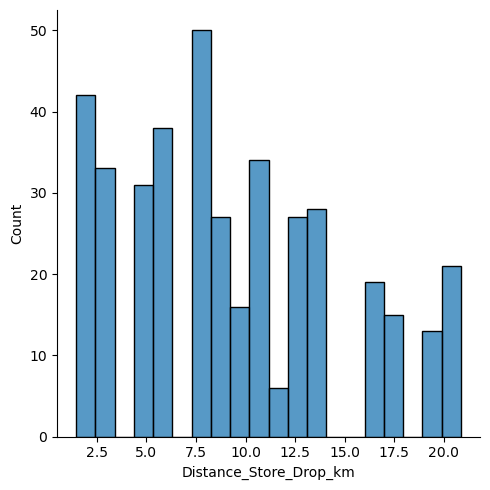

In [86]:
sns.displot(amazon_sample400["Distance_Store_Drop_km"],bins=20)

In [87]:
amazon_sample400["Distance_Store_Drop_km"].describe()

count    400.000000
mean       9.307533
std        5.422440
min        1.465125
25%        4.663399
50%        9.055724
75%       12.423656
max       20.852495
Name: Distance_Store_Drop_km, dtype: float64

<Axes: xlabel='Distance_Store_Drop_km', ylabel='Delivery_Time'>

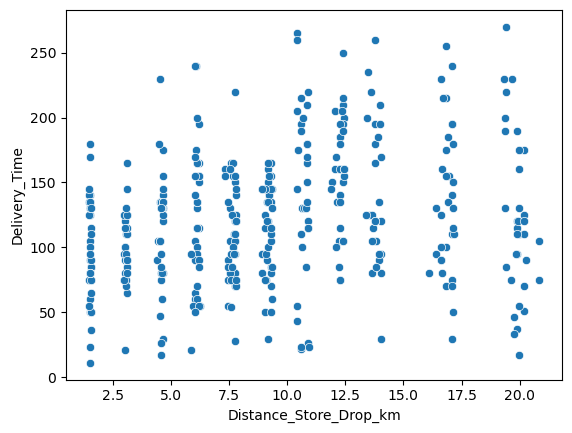

In [88]:
sns.scatterplot(x="Distance_Store_Drop_km", y="Delivery_Time", data=amazon_sample400)

<Axes: xlabel='Log_dist', ylabel='Delivery_Time'>

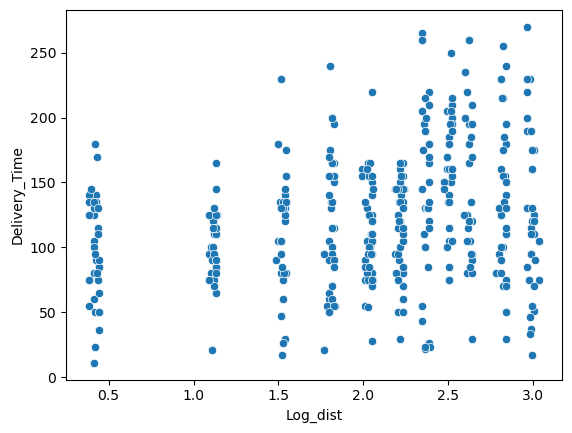

In [89]:
amazon_sample400["Log_dist"] = np.log(amazon_sample400["Distance_Store_Drop_km"])
sns.scatterplot(x="Log_dist",y="Delivery_Time", data=amazon_sample400)

In [90]:
amazon_sample400["Log_dist"].describe()

count    400.000000
mean       2.005944
std        0.744949
min        0.381940
25%        1.539745
50%        2.203397
75%        2.519602
max        3.037474
Name: Log_dist, dtype: float64

# **Categorical data**

In [91]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

## **Category**

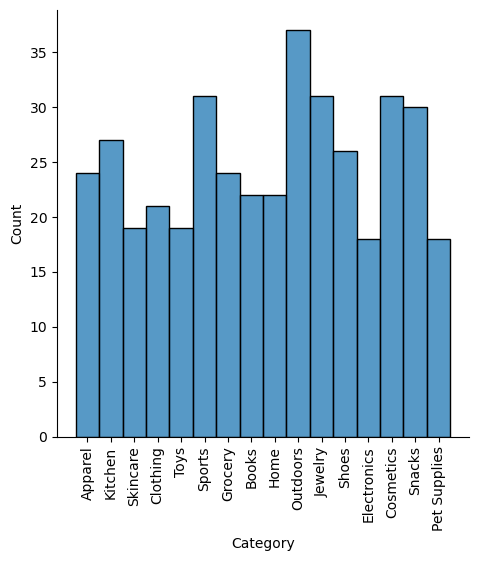

In [92]:
sns.displot(amazon_sample400["Category"])
plt.xticks(rotation=90)
plt.show()

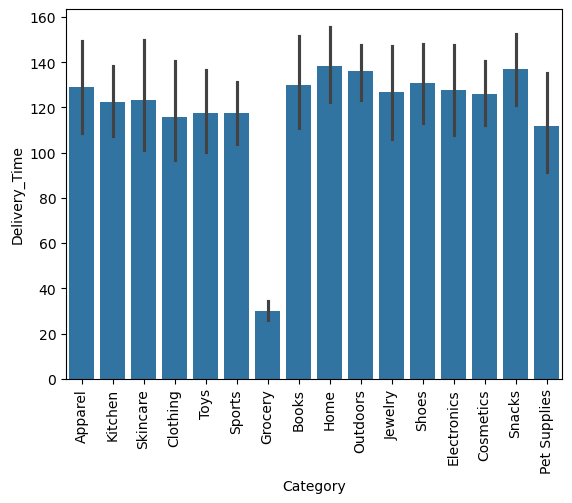

In [93]:
sns.barplot(x="Category",y="Delivery_Time", data=amazon_sample400)
plt.xticks(rotation=90)
plt.show()

Grocery has by far the shortest delivery_time. I will add a bool col.

In [94]:
amazon_sample400["Grocery_vs_not"] = np.where(amazon_sample400["Category"] == "Grocery", 1,0)

# **Datetime features**

In [95]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

## **Order_Date**

In [96]:
amazon_sample400["Order_weekday"] = amazon_sample400["Order_Date"].dt.weekday

In [97]:
amazon_sample400["Order_weekday"].describe()

count    400.000000
mean       3.055000
std        1.966378
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        6.000000
Name: Order_weekday, dtype: float64

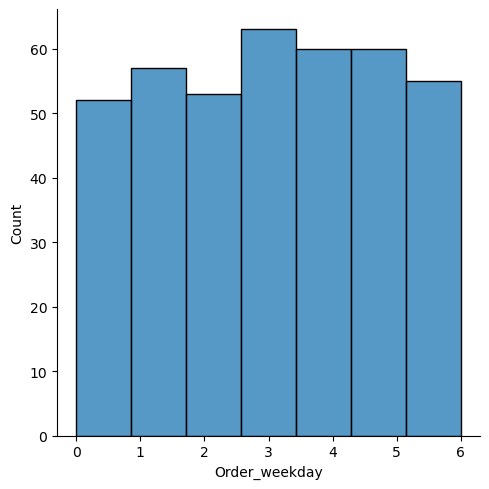

In [98]:
sns.displot(amazon_sample400["Order_weekday"], bins=7)

<Axes: xlabel='Order_weekday', ylabel='Delivery_Time'>

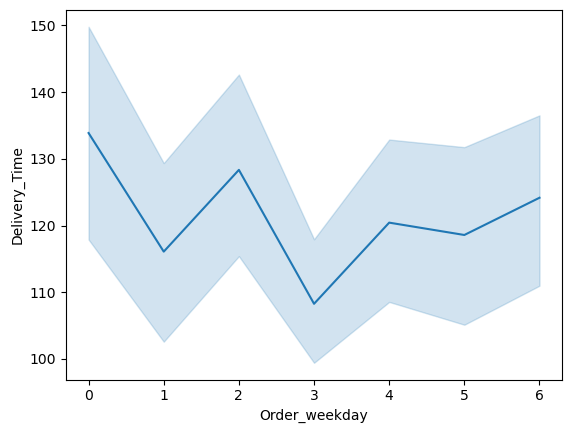

In [99]:
sns.lineplot(x="Order_weekday",y="Delivery_Time",data=amazon_sample400)

## **Order_Time**

In [100]:
amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])
amazon_sample400["Order_Time_hour"] = amazon_sample400["Order_Time"].dt.hour

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21908\1433256012.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])


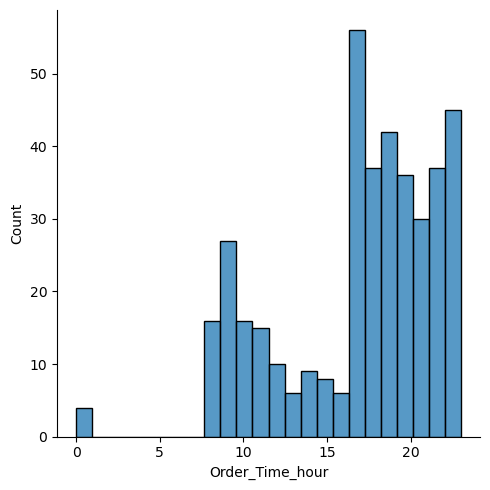

In [101]:
sns.displot(amazon_sample400["Order_Time_hour"], bins=24)

<Axes: xlabel='Order_Time_hour', ylabel='Delivery_Time'>

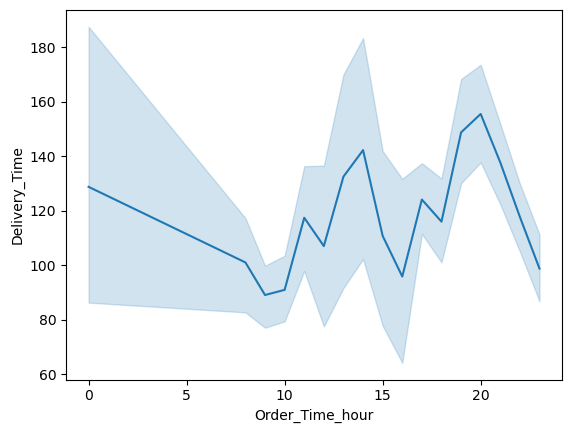

In [102]:
sns.lineplot(x="Order_Time_hour",y="Delivery_Time",data=amazon_sample400)

## **Pickup_Time**

In [103]:
amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])
amazon_sample400["Pickup_hour"] = amazon_sample400["Pickup_Time"].dt.hour

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21908\4234015629.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])


## **Removing unecessary features**

In [104]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    datetime64[ns]
 7   Pickup_Time             400 non-null    datetime64[ns]
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

In [105]:
amazon_sample400 = amazon_sample400.drop(["Order_ID","Order_Date","Order_Time","Pickup_Time","Log_dist"], axis=1)

In [106]:
amazon_sample400.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Agent_Age               400 non-null    int64   
 1   Agent_Rating            400 non-null    float64 
 2   Drop_Latitude           400 non-null    float64 
 3   Drop_Longitude          400 non-null    float64 
 4   Weather                 400 non-null    category
 5   Traffic                 400 non-null    category
 6   Vehicle                 400 non-null    category
 7   Area                    400 non-null    category
 8   Delivery_Time           400 non-null    int64   
 9   Category                400 non-null    object  
 10  Distance_Store_Drop_km  400 non-null    float64 
 11  abs_Store_Latitude      400 non-null    float64 
 12  abs_Store_Longitude     400 non-null    float64 
 13  City                    400 non-null    object  
 14  Young_vs_Older_Agents   4

# **Standardization of the numerical data**

In [120]:
numerical_features = amazon_sample400[["Agent_Age","Agent_Rating",\
                                       "Drop_Latitude","Drop_Longitude","Distance_Store_Drop_km",\
                                        "abs_Store_Latitude","abs_Store_Longitude","Order_weekday",\
                                            "Order_Time_hour","Pickup_hour"]]


In [139]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
features_scaled = pd.DataFrame(scl.fit_transform(numerical_features), columns=numerical_features.columns)

non_scaled = amazon_sample400.drop(numerical_features.columns, axis=1)

print(features_scaled.info())
print(non_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Agent_Age               400 non-null    float64
 1   Agent_Rating            400 non-null    float64
 2   Drop_Latitude           400 non-null    float64
 3   Drop_Longitude          400 non-null    float64
 4   Distance_Store_Drop_km  400 non-null    float64
 5   abs_Store_Latitude      400 non-null    float64
 6   abs_Store_Longitude     400 non-null    float64
 7   Order_weekday           400 non-null    float64
 8   Order_Time_hour         400 non-null    float64
 9   Pickup_hour             400 non-null    float64
dtypes: float64(10)
memory usage: 31.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 

In [140]:
non_scaled.reset_index(inplace=True)
non_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  400 non-null    int64   
 1   Weather                400 non-null    category
 2   Traffic                400 non-null    category
 3   Vehicle                400 non-null    category
 4   Area                   400 non-null    category
 5   Delivery_Time          400 non-null    int64   
 6   Category               400 non-null    object  
 7   City                   400 non-null    object  
 8   Young_vs_Older_Agents  400 non-null    int32   
 9   Grocery_vs_not         400 non-null    int32   
dtypes: category(4), int32(2), int64(2), object(2)
memory usage: 18.1+ KB


In [142]:
amazon_scaled_400samples = pd.concat([features_scaled,non_scaled],axis=1)
print(amazon_scaled_400samples.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Agent_Age               400 non-null    float64 
 1   Agent_Rating            400 non-null    float64 
 2   Drop_Latitude           400 non-null    float64 
 3   Drop_Longitude          400 non-null    float64 
 4   Distance_Store_Drop_km  400 non-null    float64 
 5   abs_Store_Latitude      400 non-null    float64 
 6   abs_Store_Longitude     400 non-null    float64 
 7   Order_weekday           400 non-null    float64 
 8   Order_Time_hour         400 non-null    float64 
 9   Pickup_hour             400 non-null    float64 
 10  index                   400 non-null    int64   
 11  Weather                 400 non-null    category
 12  Traffic                 400 non-null    category
 13  Vehicle                 400 non-null    category
 14  Area                    40

In [146]:
samples400_noCities = amazon_scaled_400samples.drop("City",axis=1)

# **One-hot encoding**

In [147]:
dummies = pd.get_dummies(amazon_scaled_400samples, drop_first=True)
dummies_noCities = pd.get_dummies(samples400_noCities, drop_first=True)

In [144]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 68 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Agent_Age                          400 non-null    float64
 1   Agent_Rating                       400 non-null    float64
 2   Drop_Latitude                      400 non-null    float64
 3   Drop_Longitude                     400 non-null    float64
 4   Distance_Store_Drop_km             400 non-null    float64
 5   abs_Store_Latitude                 400 non-null    float64
 6   abs_Store_Longitude                400 non-null    float64
 7   Order_weekday                      400 non-null    float64
 8   Order_Time_hour                    400 non-null    float64
 9   Pickup_hour                        400 non-null    float64
 10  index                              400 non-null    int64  
 11  Delivery_Time                      400 non-null    int64  

In [150]:
dummies = dummies.drop("index",axis=1)

In [148]:
dummies_noCities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Agent_Age               400 non-null    float64
 1   Agent_Rating            400 non-null    float64
 2   Drop_Latitude           400 non-null    float64
 3   Drop_Longitude          400 non-null    float64
 4   Distance_Store_Drop_km  400 non-null    float64
 5   abs_Store_Latitude      400 non-null    float64
 6   abs_Store_Longitude     400 non-null    float64
 7   Order_weekday           400 non-null    float64
 8   Order_Time_hour         400 non-null    float64
 9   Pickup_hour             400 non-null    float64
 10  index                   400 non-null    int64  
 11  Delivery_Time           400 non-null    int64  
 12  Young_vs_Older_Agents   400 non-null    int32  
 13  Grocery_vs_not          400 non-null    int32  
 14  Weather_Cloudy          400 non-null    bo

In [151]:
dummies_noCities = dummies_noCities.drop("index",axis=1)

In [152]:
with open("400samples_noCities.pkl","wb") as f:
    pickle.dump(dummies_noCities,f)

In [153]:
with open("400_samples_for_model.pkl","wb") as f:
    pickle.dump(dummies,f)
